# Data Augmentation

In [46]:
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [3]:
train_val_dataset = MNIST(root='../datasets/', download=True, train=True)
test_dataset = MNIST(root='../datasets/', download=False, train=False)

In [4]:
def draw_images(images):
    fig = plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        fig.add_subplot(1, len(images), i+1)
        plt.imshow(img, cmap="gray")
        plt.axis('off')

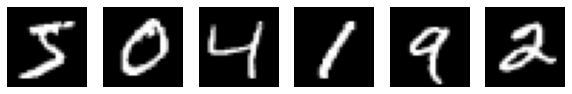

In [5]:
# original PIL images
images = [train_val_dataset[i][0] for i in range(6)]
draw_images(images)

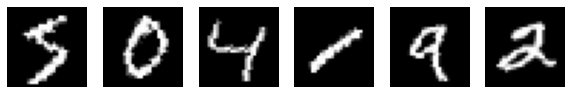

In [15]:
# rotate
transform = transforms.RandomRotation(degrees=(-30, 30))
transformed_images = [transform(img) for img in images]
draw_images(transformed_images)

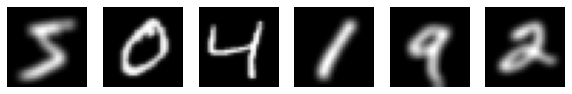

In [20]:
# gaussian blur
transform = transforms.GaussianBlur(kernel_size=(5,5))
transformed_images = [transform(img) for img in images]
draw_images(transformed_images)

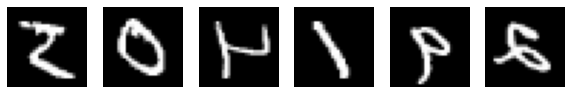

In [24]:
# flip
transform = transforms.RandomHorizontalFlip(p=1)
transformed_images = [transform(img) for img in images]
draw_images(transformed_images)

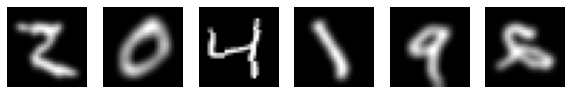

In [30]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.GaussianBlur(kernel_size=(5,5)),
    transforms.RandomHorizontalFlip(p=0.5)
])
transformed_images = [transform(img) for img in images]
draw_images(transformed_images)

In [37]:
def to_numpy(img):
    img = img.reshape(28, 28)
    return img.numpy()

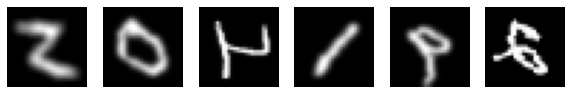

In [38]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.GaussianBlur(kernel_size=(5,5)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Lambda(to_numpy)
])
transformed_images = [transform(img) for img in images]
draw_images(transformed_images)

In [73]:
img_transform = transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.GaussianBlur(kernel_size=(5,5)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

train_dataset = MNIST(root='../datasets/', download=True, train=True, transform=img_transform)
test_dataset = MNIST(root='../datasets/', download=False, train=False, transform=transforms.ToTensor())

In [74]:
# parameters
DEVICE = ("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS=15
BATCH_SIZE=32

NUM_LABELS = 10
NUM_FEATURES = 28*28
HIDDEN_SIZE_1 = 100
HIDDEN_SIZE_2 = 50
ALPHA = 0.01

In [75]:
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True,
                              num_workers=4)

test_dataloader = DataLoader(dataset=test_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              drop_last=False,
                              num_workers=4)

In [71]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(NUM_FEATURES, HIDDEN_SIZE_1),
                nn.Sigmoid(),
                nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2),
                nn.Sigmoid(),
                nn.Linear(HIDDEN_SIZE_2, NUM_LABELS),
                nn.LogSoftmax(dim=1)
            )
    
    def forward(self, X):
        return self.layers(X)

In [65]:
model = Model().to(DEVICE)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=ALPHA)

In [80]:
def validate_epoch(model, dataloader):
    model.eval()
    with torch.inference_mode():
        num_samples = 0
        num_correct = 0
        loss_sum = 0
        batch_nums = 0

        for batch_idx, (features, labels) in enumerate(dataloader):
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            labels = labels.to(DEVICE) 
            # ------ FORWARD PASS --------
            # first linear transformation
            probs = model(features)
            loss = criterion(probs, labels)
            batch_nums+=1
            loss_sum+=loss.item()

            predictions = probs.argmax(dim=1)
            num_samples+=len(features)
            num_correct+=(labels == predictions).sum().detach().cpu().item()
            
        accuracy = num_correct / num_samples
        avg_loss = loss_sum / batch_nums
        return avg_loss, accuracy

In [81]:
for epoch in range(NUM_EPOCHS):
    loss_sum = 0
    batch_nums = 0
    model.train()
    for batch_idx, (features, labels) in enumerate(train_dataloader):
        
        # reshape features and move to gpu
        features = features.view(-1, NUM_FEATURES).to(DEVICE)
        # move label to GPU
        labels = labels.to(DEVICE)
                
        # ------ FORWARD PASS --------
        # first linear transformation
        probs = model(features)

        # ------CALCULATE LOSS --------
        #cross-entropy loss
        loss = criterion(probs, labels)

        # ------BACKPROPAGATION --------
        loss.backward()

        # ------GRADIENT DESCENT --------
        optimizer.step()

        # ------CLEAR GRADIENTS --------
        optimizer.zero_grad()
        
        # ------TRACK LOSS --------
        batch_nums += 1
        loss_sum += loss.detach().cpu()
    
    train_loss = loss_sum / batch_nums
    print(f'Epoch: {epoch+1} Train Loss: {train_loss}')

Epoch: 1 Train Loss: 2.299072027206421
Epoch: 2 Train Loss: 2.2877299785614014
Epoch: 3 Train Loss: 2.258291721343994
Epoch: 4 Train Loss: 2.147897958755493
Epoch: 5 Train Loss: 1.9072608947753906
Epoch: 6 Train Loss: 1.6298717260360718
Epoch: 7 Train Loss: 1.3543230295181274
Epoch: 8 Train Loss: 1.128679871559143
Epoch: 9 Train Loss: 0.9985739588737488
Epoch: 10 Train Loss: 0.9290108680725098
Epoch: 11 Train Loss: 0.8835063576698303
Epoch: 12 Train Loss: 0.8461393713951111
Epoch: 13 Train Loss: 0.8145990371704102
Epoch: 14 Train Loss: 0.7881186604499817
Epoch: 15 Train Loss: 0.7651550769805908


In [82]:
test_loss, test_accuracy = validate_epoch(model, test_dataloader)
print(f'Test Loss: {test_loss} Test Acc: {test_accuracy}')

Test Loss: 0.6954897904929261 Test Acc: 0.7684
